In [1]:
# Based off of https://github.com/LSSTDESC/gcr-catalogs/blob/master/examples/GCRCatalogs%20Demo.ipynb

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from scipy import stats
import os
import urllib
import requests
import shutil
from bs4 import BeautifulSoup as bs
import GCRCatalogs
from IPython.display import clear_output

print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__);

GCRCatalogs = 1.3.5 | GCR = 0.9.2


# Download the CosmoDC2 healpy files

### File paths

In [2]:
# Create a folder to store all the upcoming data
root_dir = "./root_dir/"

if not os.path.exists(root_dir):
    os.makedirs(root_dir)

### Get the links to download

In [3]:
# NERSC portal containing all the public CosmoDC2 files
url = "https://portal.nersc.gov/project/lsst/cosmoDC2/"
req = urllib.request.Request(url)
master_page = urllib.request.urlopen(req)

# Setup to crawl through the NERSC links
soup = bs(master_page)

links_tot = []

for link in soup.findAll("a")[1:]:
    if "hdf5" in link.get("href"):
        links_tot.append(url + link.get("href"))

In [4]:
# Files are stored in URLs with the format "https://portal.nersc.gov/.../z_{zmin}_{zmax}.healpix_{healpix-ID}.hdf5" for 0 < z < 3

links_z_0_1 = np.array([link for link in links_tot if "z_0_1" in link])
links_z_1_2 = np.array([link for link in links_tot if "z_1_2" in link])
links_z_2_3 = np.array([link for link in links_tot if "z_2_3" in link])

print("There are {} healpix files".format(len(links_tot)))
print("There are {} files with 0 < z < 1, {} files with 1 < z < 2, and {} files with 2 < z < 3".format(
    len(links_z_0_1), len(links_z_1_2), len(links_z_2_3)))

There are 393 healpix files
There are 131 files with 0 < z < 1, 131 files with 1 < z < 2, and 131 files with 2 < z < 3


In [5]:
# Use 0 < z < 1 for demonstration
# Only use the first two files for demonstration!

links = links_z_0_1[: 2]

# Get all the file numbers and sort them for simplicity
fnames = np.array([fname.split("/")[-1] for fname in links])
fnums = np.array([int(fname.split("_")[-1].split(".")[0]) for fname in fnames])
fnum_sort = np.argsort(fnums)

links = links[fnum_sort]
fnames = fnames[fnum_sort]
fnums = fnums[fnum_sort]

In [6]:
### This will download ~12 GB worth of healpix files! ###

for i in range(len(links)):
    if not os.path.exists(root_dir + str(links[i]).split("cosmoDC2/")[-1]):
        response = requests.head(links[i])
        fsize_GB = int(response.headers.get("content-length")) / 1e9
        print("Downloading file {} of {} ({:.2f} GB)...".format(i + 1, len(links), fsize_GB));
        os.system("wget -nv -P " + root_dir + " %s" % links[i])

    clear_output()

print("Success!");

Success!


### Setup the catalog

In [7]:
data_dir = root_dir + "data/"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [8]:
GCRCatalogs.set_root_dir(root_dir)
config_overwrite = dict(
    catalog_root_dir = root_dir,
    check_file_list_complete = False,
    check_size = False)

# See https://nbviewer.org/github/LSSTDESC/gcr-catalogs/blob/master/examples/GCRCatalogs%20Demo.ipynb
cat_name = "desc_cosmodc2"
print("Loading {}...".format(cat_name));
gc = GCRCatalogs.load_catalog(cat_name, config_overwrite)

Nchunk = len(gc.available_healpix_pixels)

print("Success!");

Loading desc_cosmodc2...
Success!


In [9]:
print("The quantities available are:");
print(np.sort([name.lower() for name in gc.list_all_quantities()]));

The quantities available are:
['a_v' 'a_v_bulge' 'a_v_disk' 'bulge_to_total_ratio_i' 'convergence' 'dec'
 'dec_true' 'ellipticity_1_bulge_true' 'ellipticity_1_disk_true'
 'ellipticity_1_true' 'ellipticity_2_bulge_true' 'ellipticity_2_disk_true'
 'ellipticity_2_true' 'ellipticity_bulge_true' 'ellipticity_disk_true'
 'ellipticity_true' 'galaxy_id' 'halo_id' 'halo_mass' 'is_central' 'mag_g'
 'mag_g_lsst' 'mag_g_lsst_no_host_extinction' 'mag_g_sdss'
 'mag_g_sdss_no_host_extinction' 'mag_i' 'mag_i_lsst'
 'mag_i_lsst_no_host_extinction' 'mag_i_sdss'
 'mag_i_sdss_no_host_extinction' 'mag_r' 'mag_r_lsst'
 'mag_r_lsst_no_host_extinction' 'mag_r_sdss'
 'mag_r_sdss_no_host_extinction' 'mag_true_g' 'mag_true_g_lsst'
 'mag_true_g_lsst_no_host_extinction' 'mag_true_g_lsst_z0'
 'mag_true_g_lsst_z0_no_host_extinction' 'mag_true_g_sdss'
 'mag_true_g_sdss_no_host_extinction' 'mag_true_g_sdss_z0'
 'mag_true_g_sdss_z0_no_host_extinction' 'mag_true_i' 'mag_true_i_lsst'
 'mag_true_i_lsst_no_host_extinction'

### Load filtered ra and dec

In [10]:
# Vary these to change the filters
ra_min, ra_max = 50, 54.5
dec_min, dec_max = -26.5, -25
zmin, zmax = 0.5, 0.67

# Format is "<quantity> <operator> <value>", e.g. "mag_r_lsst > 24" or "redshift <= 0.4"
# filters = None # to load all data
filters = ["ra >= {}".format(ra_min),
           "ra <= {}".format(ra_max),
           "dec >= {}".format(dec_min),
           "dec <= {}".format(dec_max),
           "redshift > {}".format(zmin),
           "redshift < {}".format(zmax)]

print("Filtering using", filters)

# Get lensed ra, lensed dec, redshift, and kappa for each galaxy that passes the filter
data_names = ["ra", "dec", "redshift", "convergence"]

ra, dec = [], []
redshift = []
kappa = []

# Just for printout
chunk_number = 1

# Loop through each healpix file and get data that matches the filter(s)
for data in gc.get_quantities(data_names, filters = filters, return_iterator = True):
    print("Loading data from chunk {} of {}...".format(chunk_number, Nchunk));
    ra += [data[data_names[0]]]
    dec += [data[data_names[1]]]
    redshift += [data[data_names[2]]]
    kappa += [data[data_names[3]]]
    chunk_number += 1

ra = np.hstack(ra)
dec = np.hstack(dec)
redshift = np.hstack(redshift)
kappa = np.hstack(kappa)

print("Saving ra...");
np.save(data_dir + "ra.npy", ra)
print("Saving dec...");
np.save(data_dir + "dec.npy", dec)
print("Saving redshift...");
np.save(data_dir + "redshift.npy", redshift)
print("Saving kappa...");
np.save(data_dir + "kappa.npy", kappa)

print("Success!");

Filtering using ['ra >= 50', 'ra <= 54.5', 'dec >= -26.5', 'dec <= -25', 'redshift > 0.5', 'redshift < 0.67']
Loading data from chunk 1 of 2...
Loading data from chunk 2 of 2...
Saving ra...
Saving dec...
Saving redshift...
Saving kappa...
Success!


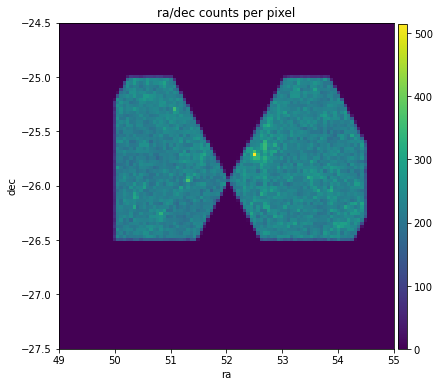

In [11]:
# These bins give the full footprint when filters = None
ra_bins = np.linspace(49, 55, 101)
dec_bins = np.linspace(-27.5, -24.5, 101)

fig, ax = plt.subplots(figsize = (6, 6))
im = ax.hist2d(ra, dec, bins = (ra_bins, dec_bins))[-1]

ax.set_xlabel("ra")
ax.set_ylabel("dec")

ax.set_title("ra/dec counts per pixel")

cbax = fig.add_axes([0.91, 0.124, 0.02, 0.754])
cbar = fig.colorbar(im, cax = cbax)

## Make maps

In [12]:
Nbins_rd = 100
ra_bins = np.linspace(53, 54, Nbins_rd + 1)
dec_bins = np.linspace(-26.5, -25.5, Nbins_rd + 1)
pix_area = np.diff(ra_bins) * np.diff(dec_bins) * 60 ** 2

# Average kappa per pixel
res = stats.binned_statistic_2d(dec, ra, kappa, statistic = "mean", bins = [dec_bins, ra_bins])
kappa_field_norm = res.statistic
# Total kappa per pixel
res = stats.binned_statistic_2d(dec, ra, kappa, statistic = "sum", bins = [dec_bins, ra_bins])
kappa_field_tot = res.statistic
# Counts per pixel
res = stats.binned_statistic_2d(dec, ra, kappa, statistic = "count", bins = [dec_bins, ra_bins])
counts_per_pixel = res.statistic

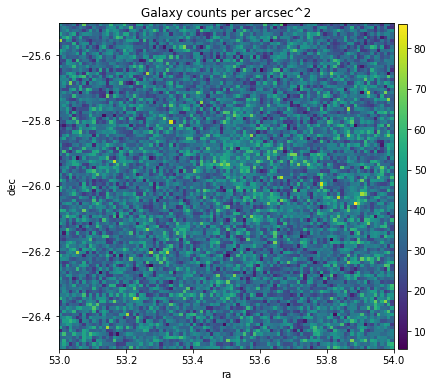

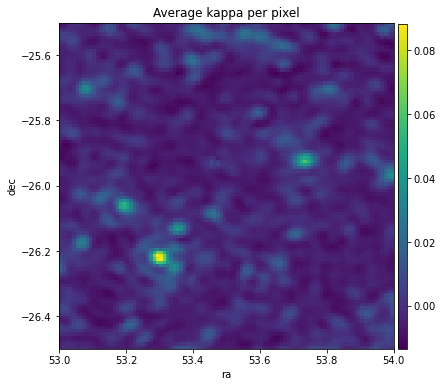

In [13]:
fig, ax = plt.subplots(figsize = (6, 6))
im = ax.pcolormesh(ra_bins, dec_bins, counts_per_pixel / pix_area)
ax.set_xlabel("ra")
ax.set_ylabel("dec")
ax.set_title("Galaxy counts per arcsec^2")

cbax = fig.add_axes([0.91, 0.124, 0.02, 0.754])
cbar = fig.colorbar(im, cax = cbax)

fig, ax = plt.subplots(figsize = (6, 6))
im = ax.pcolormesh(ra_bins, dec_bins, kappa_field_norm)
ax.set_xlabel("ra")
ax.set_ylabel("dec")
ax.set_title("Average kappa per pixel")

cbax = fig.add_axes([0.91, 0.124, 0.02, 0.754])
cbar = fig.colorbar(im, cax = cbax)